<a href="https://colab.research.google.com/github/Jefferson-Butler1/AI_ML/blob/main/Butler_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS369 Image Classifier
## Starter Code

This notebook is intended to be a starting point for writing your image classifier.

Start by setting the `root_path` variable to point to the dataset on your computer (a relative path is ok). You can verify that you're loading the data correctly by printing out the list of label names.

As is, this code loads each image and converts the image into a 1D luminance histogram. This is a very simple feature vector, and you are encouraged to experiment with more complicated ones to improve the accuracy of your predictions.

The labels, filenames, and histogram feature vectors are stored in a pandas data frame in case you want to save and load them instead of re-computing them each time.

The last part of the code trains a simple SVM classifier and computes the accuracy of the trained model on the same data it was just trained on. You're encouraged to segment the data into Train and Validation subsets, which will allow you to verify that your model isn't over-fitting to the training data.

You will need to add several components to the code, listed below. We will talk about these in class, and you can also look up the documentation for the suggested functions online.

A rubric describing how the project will be graded will be provided separately.

In [6]:
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
###unzip data
# Path to the zipped folder in your Google Drive
zip_path = '/content/drive/MyDrive/CS 369 Shared Folder/Project Resources/Intel Training Dataset.zip'

# Destination folder where the zip file will be extracted
extracted_path = './Intel\ Training\ Dataset/'

# Create the destination folder if it doesn't exist
os.makedirs(extracted_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print("Extraction complete. Data is ready for use.")


Extraction complete. Data is ready for use.


In [7]:
# Path to Dataset
root_path = '/content/Intel\ Training\ Dataset/Intel Training Dataset/'

# split into subfolders based on class label
subfolders = sorted(glob(root_path + '*'))
label_names = [p.split('/')[-1] for p in subfolders]
# print(label_names)

In [11]:
# create a list to organize labels, filenames, and images
data = []
image_height = 150
image_width = 150
channels = 3  # Assuming RGB images

for i, (label, subfolder) in enumerate(zip(label_names, subfolders)):
    # get list of file paths for each subfolder
    file_paths = sorted(glob(subfolder + '/*.jpg'))
    for f in file_paths:
        # read image and resize if necessary (adjust dimensions as needed)
        img = Image.open(f).resize((image_height, image_width))
        fname = f.split('/')[-1].split('_')[-1]

        # append to data list with labels
        data.append({'labelname': label,
                     'filename': fname,
                     'labelnum': i,
                     'image': np.array(img)})

# convert to dataframe for storage
# can also export to a file here
df = pd.DataFrame(data=data)

# Determine the number of classes
num_classes = len(df['labelnum'].unique())

# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labelnum'], random_state=42)

# Separate features (images) and labels
X_train = np.array(train_df['image'].tolist())
y_train = np.array(train_df['labelnum'])

X_test = np.array(test_df['image'].tolist())
y_test = np.array(test_df['labelnum'])

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Accuracy on Test Data with CNN: {:.2f}%'.format(test_accuracy * 100))


Epoch 1/20
246/246 [==============================] - 383s 2s/step - loss: 5.2498 - accuracy: 0.3884 - val_loss: 1.3098 - val_accuracy: 0.4827
Epoch 2/20
144/246 [================>.............] - ETA: 2:16 - loss: 1.3043 - accuracy: 0.4859

THis is where it ends


In [ ]:
# re-load data
label_array = df['labelnum'] # vector
feature_matrix = np.vstack(df['features']) #2D for lumhist


In [ ]:
# Split the combined features into train and test sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    feature_matrix,
    label_array,
    test_size=0.2,
    stratify=label_array,
    random_state=42
    )

# Standardize the features
scaler = StandardScaler()
X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)

# Train a Gradient Boosting classifier
gb_clf_combined = GradientBoostingClassifier(n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    max_features='sqrt',
    random_state=0,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=0.001,)
gb_clf_combined.fit(X_train_combined_scaled, y_train_combined)

# #Train a Random Forest model
# rf_clf_combined = RandomForestClassifier(n_estimators = 50,
#                                   max_depth = 7,
#                                   min_samples_split = 6,
#                                   min_samples_leaf = 8,
#                                   max_features = 'sqrt',
#                                   bootstrap = False)
# rf_clf_combined.fit(X_train_combined_scaled, y_train_combined)

# Report accuracy on the test data

# test_predictions_combined_rf = rf_clf_combined.score(X_test_combined_scaled, y_test_combined)
# print('Accuracy on Test Data with Combined Features & Random Forest: {:.2f}%'.format(test_predictions_combined_rf * 100))


Accuracy on Test Data with Combined Features & Gradient Boosting: 75.56%


In [ ]:

test_predictions_combined_gb = gb_clf_combined.score(X_train_combined_scaled, y_train_combined)
print('Accuracy on Train Data with Combined Features & Gradient Boosting: {:.2f}%'.format(test_predictions_combined_gb * 100))

test_predictions_combined_gb = gb_clf_combined.score(X_test_combined_scaled, y_test_combined)
print('Accuracy on Test Data with Combined Features & Gradient Boosting: {:.2f}%'.format(test_predictions_combined_gb * 100))


Accuracy on Train Data with Combined Features & Gradient Boosting: 96.05%
Accuracy on Test Data with Combined Features & Gradient Boosting: 75.56%


In [ ]:
# Train a Neural Network classifier
nn_clf_combined = MLPClassifier(hidden_layer_sizes=(100,50),
                                activation='relu',
                                solver='adam',
                                alpha=0.01,
                                max_iter=500,
                                random_state=42)
nn_clf_combined.fit(X_train_combined_scaled, y_train_combined)

# Report accuracy on the test data
test_predictions_combined_nn = nn_clf_combined.score(X_train_combined_scaled, y_train_combined)
print('Accuracy on Train Data with Combined Features & Neural Network: {:.2f}%'.format(test_predictions_combined_nn * 100))
test_predictions_combined_nn = nn_clf_combined.score(X_test_combined_scaled, y_test_combined)
print('Accuracy on Test Data with Combined Features & Neural Network: {:.2f}%'.format(test_predictions_combined_nn * 100))

In [ ]:
# Report accuracy on the test data
test_predictions_combined_nn = nn_clf_combined.score(X_train_combined_scaled, y_train_combined)
print('Accuracy on Train Data with Combined Features & Neural Network: {:.2f}%'.format(test_predictions_combined_nn * 100))
test_predictions_combined_nn = nn_clf_combined.score(X_test_combined_scaled, y_test_combined)
print('Accuracy on Test Data with Combined Features & Neural Network: {:.2f}%'.format(test_predictions_combined_nn * 100))

Accuracy on Train Data with Combined Features & Neural Network: 99.95%
Accuracy on Test Data with Combined Features & Neural Network: 68.84%


In [ ]:
# Split lumhist into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_lum, label_array, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Report accuracy on the test data
test_predictions = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
print('Accuracy on Test Data: {:.2f}%'.format(accuracy * 100))

Accuracy on Test Data: 46.79%


In [ ]:
# Split hog into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_hog, label_array, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Report accuracy on the test data
test_predictions = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
print('Accuracy on Test Data: {:.2f}%'.format(accuracy * 100))

Accuracy on Test Data: 63.85%


In [ ]:
# Split hog into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix_hog, label_array, test_size=0.2, random_state=42)

# Train a Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)

# Report accuracy on the test data
test_predictions_gb = gb_clf.predict(X_test)
accuracy_gb = accuracy_score(y_test, test_predictions_gb)
print('Accuracy on Test Data with Gradient Boosting: {:.2f}%'.format(accuracy_gb * 100))

Accuracy on Test Data with Gradient Boosting: 67.57%


In [ ]:
### from starter code
# train a simple classifier
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(feature_matrix_lum, label_array)

# report overall accuracy on the training data
print('Total Accuracy: {}'.format(clf.score(feature_matrix_lum, label_array)))

Total Accuracy: 0.4985743380855397


In [ ]:
# Project To Do's
# 0. split the data into Train and Validation sets
# 1. use sklearn.metrics.confusion_matrix to get more detailed results
# 2. use sklearn.model_selection.GridSearchCV to try different params
# 3. try different feature vectors and classifiers to improve accuracy
# 4. use python's time.time() function to measure compute time costs

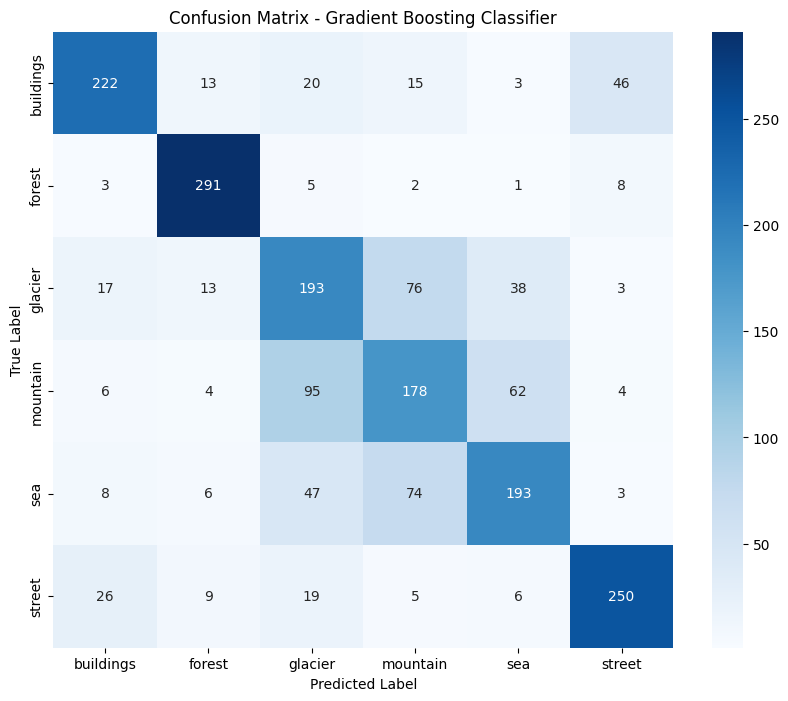

In [ ]:
### confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix_gb = confusion_matrix(y_test, test_predictions_gb)

# Visualize confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_gb, annot=True, cmap='Blues', fmt='d', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.show()
